# Inspect direct beam histogram with QuantiCam
- [X] Redirect laser elongated profile directly into the sensor to observe sharp peak without internal reflection from the obscure box
- [X] HDF5 data acquisition stream
- [ ] Peak detection algorithm employed
- [ ] Model Poission noise for the direct path

| Layout | Illumination |
|:--------:|:--------|
| ![alt text](./img/PXL_20250317_Direct_Laser_Hist_Layout.jpg "Beam path") | ![alt text](./img/PXL_20250317_Direct_Laser_Hist_DarkIllumination.jpg "Beam path") |  

In [2]:
using QuantiCam

## Setup connection to the QC FPGA
- Write FW
- Config voltages
- Config sensor settings for the mode we use

In [28]:
if (@isdefined qc) && qc!== nothing
    # Try to reconfigure or cleanup and initialise from the begining
    try
        QuantiCam.reload_config(qc, "../config/tcspc.json")
        QuantiCam.config_sensor(qc)
    catch
        #QuantiCam.sensor_disconnect(qc)
        QuantiCam.cleanup(qc)
    end
end
if !(@isdefined qc) || qc === nothing
    qc = QCBoard("../hw/TOP_7310_modes_1_2.bit", "../config/tcspc.json")
    init_board!(qc)
end

[ Info: Reset sensor and set parameters for the MODE of use


[ Info: Sensor configured


In [46]:
#QuantiCam.sensor_disconnect(qc)
QuantiCam.cleanup(qc)

[ Info: Disconnected from Sensor
[ Info: Cleaning up FPGA connection to OK FrontPanel
[ Info: FPGA desctructed! => Safe exit


## Capture

Next we have a few different methods to read from the sensor and display or save the data

### One frame visualize
Just read one frame and display it

In [ ]:
using Plots

println("Reading a frame with el_size=$(QuantiCam.element_size(qc)) and frame_size=$(QuantiCam.frame_size(qc))")
frame_raw = QuantiCam.capture_raw(qc);
println(typeof(frame_raw))
println(size(frame_raw))
println(QuantiCam.element_size(qc))

display(heatmap(frame_raw))

## TCSPC Histogram
- [ ] Aquire N tcspc frames
- [ ] Make histogram for each pixel

In [29]:
number_of_frames = 1000
frames = QuantiCam.capture_frames(qc, number_of_frames)
filtered_frames = map(frame -> QuantiCam.filter_code(frame), frames)

1000-element Vector{Matrix{Union{Missing, Float32}}}:
 [95.0 0.0 … missing missing; 94.0 0.0 … missing missing; … ; missing missing … missing missing; missing missing … missing missing]
 [95.0 0.0 … missing 252.0; 94.0 0.0 … missing 111.0; … ; missing missing … missing missing; missing 25.0 … missing 242.0]
 [95.0 0.0 … missing 228.0; 94.0 0.0 … missing 114.0; … ; missing missing … missing missing; missing missing … missing 218.0]
 [95.0 0.0 … missing 0.0; 94.0 0.0 … missing 113.0; … ; missing missing … missing missing; missing missing … missing 247.0]
 [95.0 0.0 … missing 3.0; 94.0 0.0 … missing 97.0; … ; missing missing … missing missing; missing missing … missing 251.0]
 [95.0 0.0 … missing 7.0; 94.0 0.0 … missing 106.0; … ; missing missing … missing missing; missing missing … missing 253.0]
 [95.0 0.0 … missing 252.0; 94.0 0.0 … missing 111.0; … ; missing missing … missing missing; missing missing … missing 242.0]
 [95.0 0.0 … missing 217.0; 94.0 0.0 … missing 119.0; … ; missing mi

WebIO._IJuliaInit()

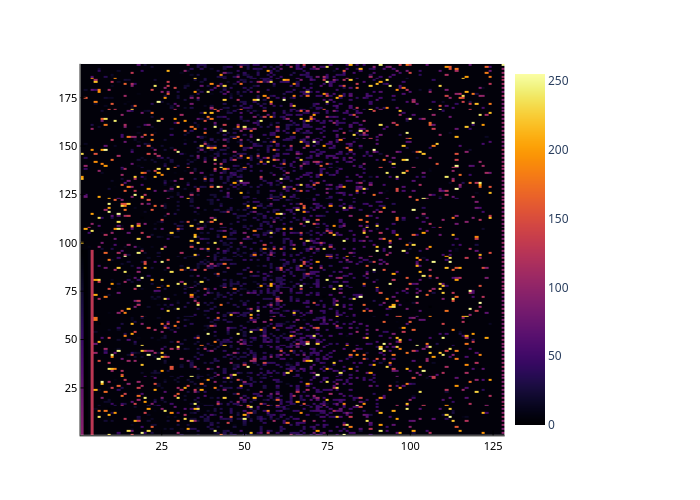

In [31]:
using Plots
plotlyjs()
heatmap(frames[5])

In [24]:
filtered_frames = map(frame -> QuantiCam.filter_code(frame), frames)
typeof(filtered_frames)

Vector{Matrix{Union{Missing, Float32}}} (alias for Array{Array{Union{Missing, Float32}, 2}, 1})

In [32]:
using Statistics

function collect_frames(v::Vector{Matrix{T}}) where T
    n_rows = size(v[1], 1)
    n_cols = size(v[1], 2)
    n_matrices = length(v)
    
    result = Matrix{Vector{T}}(undef, n_rows, n_cols)
    
    for i in 1:n_rows, j in 1:n_cols
        result[i, j] = [v[k][i, j] for k in 1:n_matrices]
    end
    
    return result
end

#tcspc_stream = collect_frames([frames[:,:,i] for i in 1:size(frames,3)])
tcspc_stream = collect_frames(filtered_frames)
tcspc_mean = map(pixel -> mean(pixel), tcspc_stream)
tcspc_var = map(pixel -> var(pixel), tcspc_stream)

192×128 Matrix{Union{Missing, Float32}}:
 0.0       0.0       missing  …  missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing  …  missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing  …  missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 0.0       0.0       missing     missing  missing  missing  missing
 ⋮                            ⋱           ⋮                 
  missing   mi

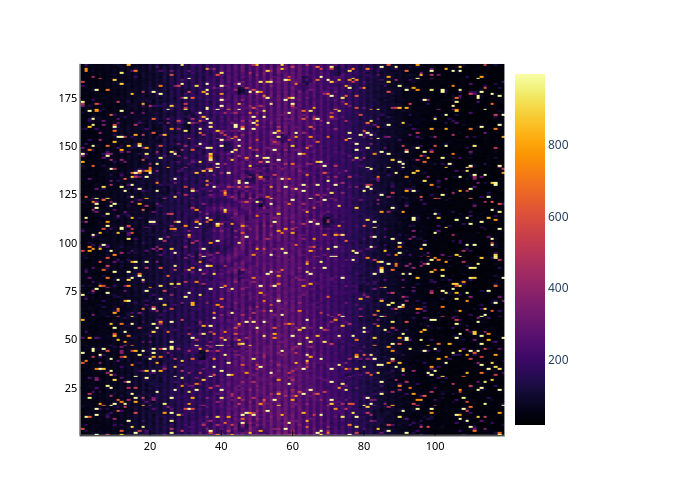

In [33]:
using Plots
frames_center = map(frame -> frame[1:192, 5:123], filtered_frames)
tcspc_events = map(pixel -> length(collect((skipmissing(pixel)))), tcspc_stream)
#heatmap(map(pixel -> length(collect((skipmissing(pixel)))), tcspc_stream))
#heatmap(map(pixel -> sum(collect((skipmissing(pixel)))), collect_frames(frames_center)))
heatmap(tcspc_events[:,5:123])
#heatmap(filtered_frames[24])

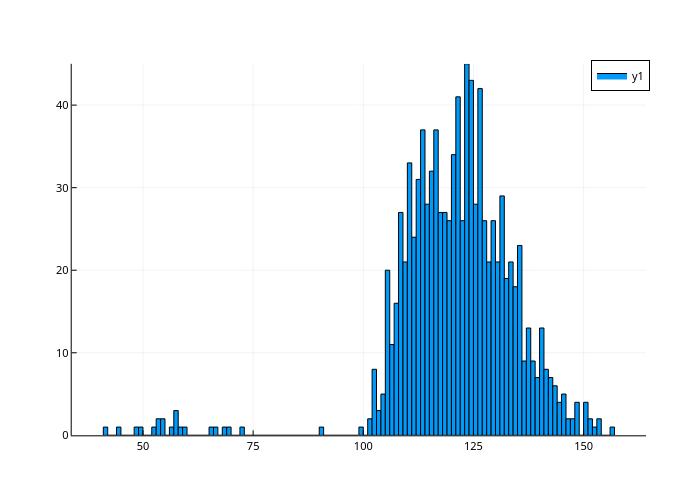

In [45]:
histogram(tcspc_stream[100, 128], bins=200)

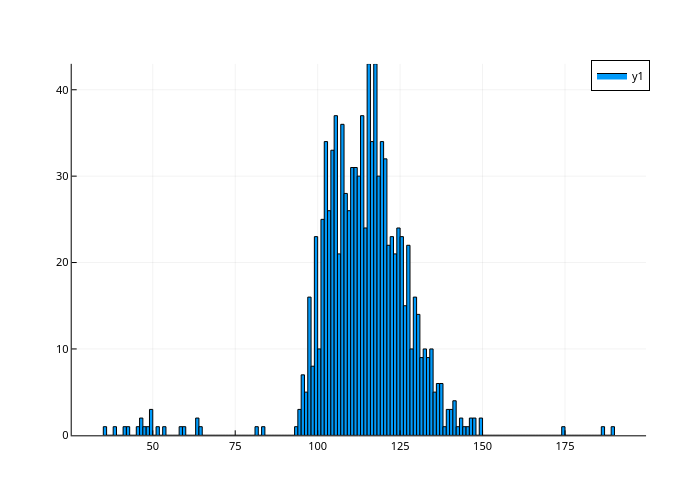

In [43]:
histogram(tcspc_stream[40, 128], bins=200)

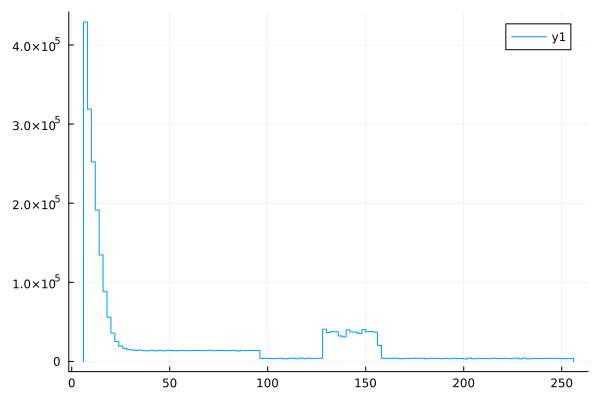

In [105]:
all_pixels = collect(Iterators.filter(x-> x>2.0, skipmissing(Iterators.flatten(tcspc_stream))))
histogram(all_pixels, bins=200)

In [86]:
QuantiCam.cleanup(qc)

[ Info: Disconnected from Sensor
[ Info: Cleaning up FPGA connection to OK FrontPanel
[ Info: FPGA desctructed! => Safe exit
